In [ ]:
import numpy as np
def f_radar(x, dt):
  """ state transition function for a constant velocity
  aircraft with the state vector [distance, velocity, altitude]"""
  F = np.array([[1, dt, 0], [0, 1, 0], [0, 0, 1]])
  return np.dot(F, x)

In [ ]:
from math import sqrt
from numpy import arctan2
def h_radar(x , radar_pos):
  """Measurement function, return a list [slant_range, elevation_angle] """
  dim_x = x[0] - radar_pos[0]
  dim_y = x[2] - radar_pos[1]
  slant_range = sqrt(dim_x**2 + dim_y**2)
  elevation_angle = arctan2(dim_y, dim_x)
  return [slant_range, elevation_angle]

In [ ]:
from numpy.linalg import norm
from numpy import arctan2
from numpy.random import randn

class RadarStation:
    def __init__(self, pos, range_std, elev_angle_std):
      self.pos = np.asarray(pos)       
      self.range_std = range_std
      self.elev_angle_std = elev_angle_std


    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft.
        Elevation angle is in radians.
        """
        pos_diff = np.subtract(ac_pos, self.pos)
        range = norm(pos_diff)
        elev_angle = arctan2(pos_diff[1], pos_diff[0])
        return range, elev_angle


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with
        simulated noise"""
        range, elev_angle = self.reading_of(ac_pos)      
        range += randn() * self.range_std
        elev_angle += randn() * self.elev_angle_std 
        return range, elev_angle       


class ACSim:
  def __init__(self, posi, velo, velo_std):
    self.posi = np.asarray(posi)
    self.velo = np.asarray(velo)
    self.velo_std = velo_std  
  
  
  def update(self, dt):
    """ Compute and returns next position. Incorporates
    random variation in velocity. """
    dx = self.velo*dt + (randn() * self.velo_std) * dt      
    self.posi += dx     
    return self.posi

In [ ]:
class UKF:
    """
    Implements the Scaled Unscented Kalman filter (UKF).
    This filter scales the sigma points to avoid strong nonlinearities.

    Parameters
    ----------
    dim_x : int
        Number of state variables for the filter. For example, if
        you are tracking the position and velocity of an object in two
        dimensions, dim_x would be 4.
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
        This is for convience, so everything is sized correctly on
        creation. If you are using multiple sensors the size of `z` can
        change based on the sensor. Just provide the appropriate hx function
    dt : float
        Time between steps in seconds.
    hx : function(x,**hx_args)
        Measurement function. Converts state vector x into a measurement
        vector of shape (dim_z).
    fx : function(x,dt,**fx_args)
        function that returns the state x transformed by the
        state transition function. dt is the time step in seconds.
    radar_pos: radar position

    Attributes
    ----------
    mu : numpy.array(dim_x)
        state estimate vector
    Sigma : numpy.array(dim_x, dim_x)
        covariance estimate matrix
    mup : numpy.array(dim_x)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.
    Sigmap : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.
    z : ndarray
        Last measurement used in update(). Read only.
    Q : numpy.array(dim_z, dim_z)
        measurement noise matrix
    R : numpy.array(dim_x, dim_x)
        process noise matrix
    K : numpy.array
        Kalman gain
    y : numpy.array
        innovation residual
    """
    def __init__(self, dim_x, dim_z, dt, hx, fx, radar_pos):
        """
        Create a Kalman filter. You are responsible for setting the
        various state variables to reasonable values; the defaults below will
        not give you a functional filter.
        """
        self._dim_x = dim_x
        self._dim_z = dim_z
        self._dt = dt
        self.hx = hx
        self.fx = fx
        self.radar_pos = radar_pos
        self.mu = np.zeros(dim_x)
        self.Sigma = np.eye(dim_x)
        self.mup = np.copy(self.mu)
        self.Sigmap = np.copy(self.Sigma)
        self.Q = np.eye(dim_z)
        self.R = np.eye(dim_x)
        self.K = np.zeros((dim_x, dim_z))

    def predict(self):
      """ Performs the predict step of the UKF. On return,
      self.mup and self.Sigmap contain the predicted state (mu)
      and covariance (Sigma). 'p' stands for prediction.
      """
      # calculate sigma points for given mean and covariance
      sigmas = self.SigmaPoints()
      sigmas_f = np.zeros(sigmas.shape)

      for i in range(len(sigmas)):
          sigmas_f[i] = self.fx(sigmas[i], self._dt)
      self.mup, self.Sigmap = self.unscented_transform(sigmas_f, self.R)
      return self.mup, self.Sigmap, sigmas_f


    def update(self, z):
      self.mup, self.Sigmap, sigmas_f = self.predict()
      sigmas_h = np.zeros((len(sigmas_f),self._dim_z))
      self.lambda_ , self.wc, self.wm = self.MerweWeightSigmaPoints()
   
      for i in range(len(sigmas_f)):
        sigmas_h[i] = self.hx(sigmas_f[i], self.radar_pos)

      # mean and covariance of prediction passed through UT
      zp, Pz = self.unscented_transform(sigmas_h, self.Q)

      # compute cross variance of the state and the measurements
      Pxz = np.zeros((len(self.mup), len(zp)))
      for i in range(len(sigmas_f)):
          Pxz += self.wc[i] * np.outer(sigmas_f[i] - self.mup, sigmas_h[i] - zp)

      K = np.dot(Pxz, np.linalg.inv(Pz))  # Kalman gain

      self.mu = self.mup + np.dot(K, z - zp)
      self.Sigma = self.Sigmap - np.dot(K, Pz).dot(K.T)
      return self.mu, self.Sigma


    def MerweWeightSigmaPoints(self, alpha=.1, beta=2., kappa=0.):
      n = self._dim_x
      lambda_ = alpha ** 2 * (n + kappa) - n
      wc = np.full(2 * n + 1, 1.0 / (2 * (n + lambda_)))
      wm = np.full(2 * n + 1, 1.0 / (2 * (n + lambda_)))
      wc[0] = lambda_ / (n + lambda_) + (1.0 - alpha ** 2 + beta)
      wm[0] = lambda_ / (n + lambda_)
      return lambda_, wc, wm
     
    def SigmaPoints(self):
      self.lambda_, self.wc, self.wm = self.MerweWeightSigmaPoints()
      n = self._dim_x
      sigmas = np.zeros((2 * n + 1, n))
      U = np.linalg.cholesky((n + self.lambda_) * self.Sigma)  # sqrt

      sigmas[0] = self.mu
      for k in range(n):
          sigmas[k + 1] = self.mu + U[k]
          sigmas[n + k + 1] = self.mu - U[k]
      return sigmas
     

    def unscented_transform(self, sigmas, cov):
      self.lambda_ , self.wc, self.wm = self.MerweWeightSigmaPoints()
      mu = np.dot(self.wm, sigmas)
      kmax, n = sigmas.shape
    
      P = np.zeros((n, n))
      for k in range(kmax):
          y = sigmas[k] - mu
          P += self.wc[k] * np.outer(y, y)
      P += cov
      return mu, P

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:, 0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        plt.tight_layout()
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:, 1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')
        plt.tight_layout()
    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.tight_layout()
    plt.show()

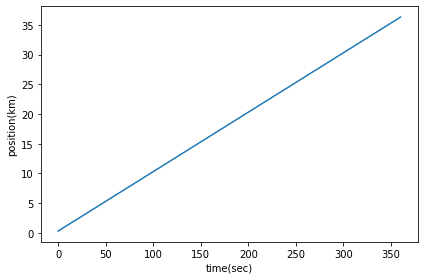

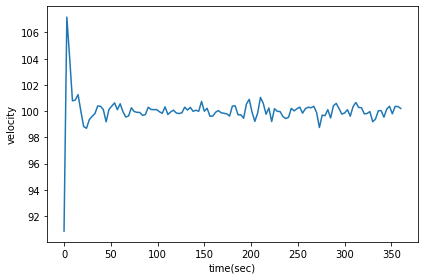

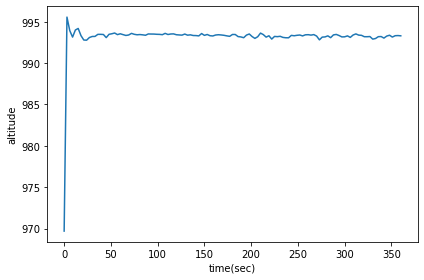

In [ ]:
import math
import random

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)

kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, radar_pos=radar_pos)

kf.R[0:2, 0:2] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])
kf.R[2,2] = 0.1

kf.Q = np.diag([range_std**2, elevation_angle_std**2])
kf.mu = np.array([0., 90., 1000.])
kf.Sigma = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.posi)
    kf.predict()
    kf.update([r[0], r[1]])
    xs.append(kf.mu)
plot_radar(xs, time)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_altitude(xs, t, track):
    xs = np.asarray(xs)

    plt.plot(t, xs[:,2], label='filter', )
    plt.plot(t, track, label='Aircraft', lw=2, ls='--', c='k')
    plt.xlabel('time(sec)')
    plt.ylabel('altitude')
    plt.legend(loc=4)

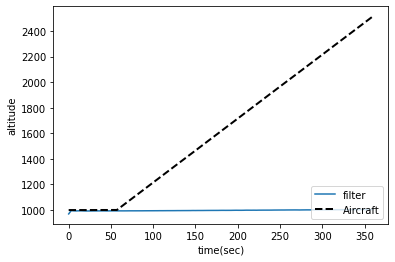

In [ ]:
import math
import random

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)

kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, radar_pos=radar_pos)

kf.R[0:2, 0:2] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])
kf.R[2,2] = 0.1

kf.Q = np.diag([range_std**2, elevation_angle_std**2])
kf.mu = np.array([0., 90., 1000.])
kf.Sigma = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.velo[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.posi)
    ys.append(ac.posi[1])
    kf.predict()
    kf.update([r[0], r[1]])
    xs.append(kf.mu)

plot_altitude(xs, time, ys)

In [ ]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity
    aircraft"""
    F = np.array([[1, dt, 0,  0], [0,  1, 0,  0], [0,  0, 1, dt], [0,  0, 0,  1]])
    return np.dot(F, x)

In [ ]:
def cv_UKF(fx, hx, Q_std):
    # Implement the function here...
    ## Radar Pos here is assumed 
    kf = UKF(4, len(Q_std), dt, fx=fx, hx=hx, radar_pos=(0.,1000.))

    kf.R[0:2, 0:2] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])
    kf.R[2:4, 2:4] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])

    kf.Q = np.diag(Q_std)
    kf.Q = np.dot(kf.Q, kf.Q)  # Creating Q by squaring to get variance
    kf.mu = np.array([0., 90., 1100., 0.])
    kf.Sigma = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

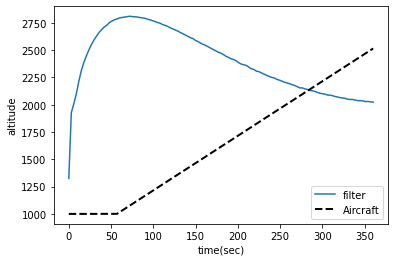

In [ ]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_cv = cv_UKF(f_cv_radar, h_radar, Q_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.velo[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.posi)
    ys.append(ac.posi[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]])
    xs.append(kf_cv.mu)

plot_altitude(xs, time, ys)